# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


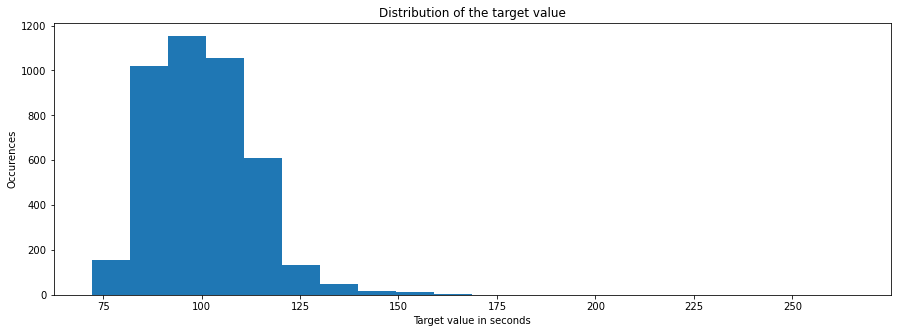

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [4]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [5]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

<ipython-input-5-86fbcd4c84a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[column] = x_train[column].apply(mapper)


,X279,X314,X182,X324,X184,X157,X317,X75,X289,X371,...,X17,X142,X360,X159,X217,X243,X181,X250,X281,X267
0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [6]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [7]:
from sklearn.utils import shuffle

In [8]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [9]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [10]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [11]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

Для случайного леса самый важный гиперпараметр - max_features (сколько случайно выбранных признаков перебирать при построении вершины), потому что он влияет на то, насколько различными будут деревья (а это основная идея случайного леса). В частности, если вы меняете признаковое пространство (а значит, и число признаков), то этот гиперпараметр надо подбирать заново. После настройки max_features подбираются остальные гиперпараметры.

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбирают другие гиперпараметры. 

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split. В этом пункте не нужно строить график, только выбрать лучшее значение. Обратите внимание, что в этом пункте нужно использовать max_features, выбранное на предыдущем шаге.
1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. Если вы перезапускаете ядро, старайтесь не перезапускать все ячейки перебора гиперпараметров (они могут долго считаться, кроме того, могут измениться оптимальные гиперпараметры, если вы не везде зафиксировали random state), перезапускайте только те ячейки, результаты которых используются дальше. В данном блоке это только ячейка, отвечающая за последний пункт (итоговое обучение случайного леса).

Если вдруг получилось, что вы перезапустили ячейки с grid search, и у вас изменились оптимальные гиперпараметры, при этом ранее полученные гиперпараметры уже использованы ниже в ноутбуке, напишите об этом пояснение и не переделывайте другие задания.

In [13]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [14]:
gs.fit(x1, y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-0.393, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-1.448, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-0.055, total=   0.1s
[CV] n_estimators=2 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ...................... n_estimators=2, score=0.183, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ..................... n_estimators=2, score=-0.285, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.146, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ...................... n_estimators=4, score=0.352, total=   0.3s
[CV] n_estimators=4 ..................................................
[CV] ...................... n_estimators=4, score=0.293, total=   0.3s
[CV] n_estimators=4 ..................................................
[CV] ...................... n_estimators=4, score=0.265, total=   0.3s
[CV] n_estimators=8 ..................................................
[CV] ...................... n_estimators=8, score=0.460, total=   0.6s
[CV] n_estimators=8 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.2min finished


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(random_state=1, warm_start=True),
             param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
             scoring=make_scorer(r2_score), verbose=3)

Text(0, 0.5, 'R2')

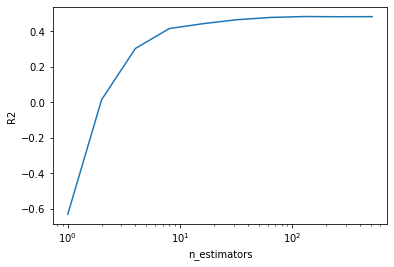

In [15]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [16]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}

In [17]:
gs = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=1, warm_start=True), 
                  param_grid, make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [18]:
gs.fit(x1, y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.437, total=   1.0s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ...................... max_features=2, score=0.550, total=   1.0s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ...................... max_features=2, score=0.298, total=   1.0s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.459, total=   1.0s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.577, total=   1.0s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.318, total=   0.9s
[CV] max_features=8 ..................................................
[CV] ...................... max_features=8, score=0.479, total=   1.0s
[CV] max_features=8 ..................................................
[CV] ...................... max_features=8, score=0.609, total=   1.0s
[CV] max_features=8 ..................................................
[CV] ...................... max_features=8, score=0.341, total=   1.0s
[CV] max_features=16 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   42.0s finished


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(random_state=1, warm_start=True),
             param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)},
             scoring=make_scorer(r2_score), verbose=3)

Text(0, 0.5, 'R2')

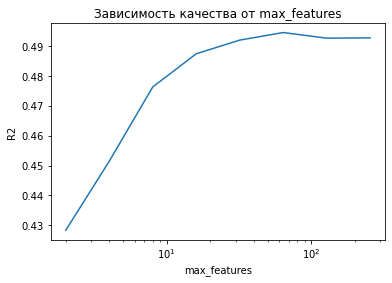

In [19]:
plt.title("Зависимость качества от max_features")
plt.plot((param_grid["max_features"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

In [20]:
gs.cv_results_['mean_test_score']

array([0.42833169, 0.45146055, 0.47633241, 0.48745077, 0.49202827,
       0.49456446, 0.49267847, 0.49277926])

In [21]:
param_grid["max_features"]

array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)

Результат соответствует ожиданиям -  поначалу повышение количества max_features приводит к повышению качества, но когда max_features достигает 64, качество начинает понижаться. Стоит взять max_features, равное 64, так как качество на нем максимально.

In [22]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), 
              "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}

In [23]:
gs = GridSearchCV(RandomForestRegressor(n_estimators=100, max_features=64, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [24]:
gs.fit(x1, y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.321, total=   0.4s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.371, total=   0.4s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.218, total=   0.4s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.321, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.371, total=   0.4s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.218, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.321, total=   0.4s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.371, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.6min finished


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features=64, random_state=1,
                                             warm_start=True),
             param_grid={'max_depth': array([1, 3, 5, 7]),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring=make_scorer(r2_score), verbose=3)

In [25]:
order = np.argsort(gs.cv_results_['mean_test_score'])
cv_res = np.array(gs.cv_results_['params'])
cv_res[np.array(order)][-1]

{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 81}

Лучшие результаты получены при следующих значениях {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 81}
Обучаю случайный лес с выбранными параметрами.

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, max_features=64, max_depth=7, min_samples_leaf=3, 
                                 min_samples_split=81, random_state=1)

In [27]:
rf_model.fit(x1,y1)

RandomForestRegressor(max_depth=7, max_features=64, min_samples_leaf=3,
                      min_samples_split=81, random_state=1)

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1.  __(1.5 балла)__ Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). При построении графиков используйте логарифмическую шкалу по оси абсцисс (вызовите np.log2 или используйте plt.xscale("log")). Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации. В этом пункте не нужно строить график. Обратите внимание, что в этом пункте нужно исползьзовать ранее выбранные гиперпараметры.
1.  __(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [28]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}

In [29]:
gs = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, 
                                            make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [30]:
gs.fit(x1,y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.546, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.669, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.408, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.545, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.649, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.401, total=   0.0s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV] ... learni

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.5min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(random_state=1,
                                                 warm_start=True),
             param_grid={'learning_rate': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
             scoring=make_scorer(r2_score), verbose=3)

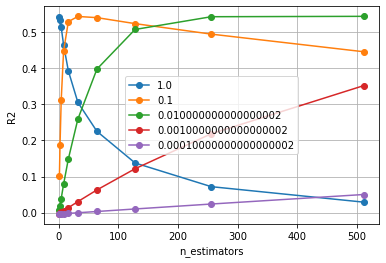

In [31]:
r2_mean = gs.cv_results_['mean_test_score']
r2_mean = np.array(r2_mean).reshape(len(param_grid["learning_rate"]),len(param_grid["n_estimators"]))
_, ax = plt.subplots(1,1)

for idx, val in enumerate(param_grid["learning_rate"]):
    ax.plot(param_grid["n_estimators"], r2_mean[idx,:], '-o', label = str(val))

ax.set_xlabel("n_estimators")
ax.set_ylabel('R2')
ax.legend(loc="best")
ax.grid('on')

График демонстрирует вполне ожидаемые результаты. Видно, что при маленьком learning_rate, например, 0.0001, модель показывает плохие результаты даже при большом количестве n_estimators. При большом learning_rate модель быстро переобучается при больших n_estimators. Выбираю learning_rate=0.01 и n_estimators=256, так как лучший результат на графике начинает достигаться именно с такими значениями.

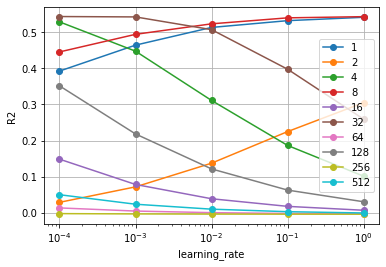

In [32]:
r2_mean = gs.cv_results_['mean_test_score']
r2_mean = np.array(r2_mean).reshape(len(param_grid["n_estimators"]),len(param_grid["learning_rate"]))
_, ax = plt.subplots(1,1)

for idx, val in enumerate(param_grid["n_estimators"]):
    ax.plot(param_grid["learning_rate"], r2_mean[idx,:], '-o', label = str(val))

ax.set_xlabel("learning_rate")
plt.xscale("log")
ax.set_ylabel('R2')
ax.legend(loc="best")
ax.grid('on')

Результаты на графике ожидаемы в том плане, что при повышении learning_rate качество падает (модель переобучается), а для маленьких значений n_estimators модель недообучается даже при большом learning_rate. Однако я не ожидала, что модели с большим количеством n_estimators будут показывать плохие результаты вне зависимости от learning_rate. Так как градиентный бустинг относительно устойчив к переобучению в части количества деревьев, возьму n_estimators = 256, как и решила в предудущем шаге.

In [33]:
order = np.argsort(gs.cv_results_['mean_test_score'])
cv_res = np.array(gs.cv_results_['params'])
cv_res[np.array(order)][-1]

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

In [34]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}

In [35]:
gs = GridSearchCV(GradientBoostingRegressor(learning_rate=0.01 , n_estimators=256 , random_state=1, 
                                            warm_start=True), param_grid, make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [36]:
gs.fit(x1,y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.431, total=   1.7s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.550, total=   1.8s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.335, total=   1.8s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.533, total=   3.2s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.671, total=   3.1s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.409, total=   3.2s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.540, total=   4.6s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.674, total=   4.6s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.413, total=   4.6s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.4min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                 n_estimators=256,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring=make_scorer(r2_score), verbose=3)

Text(0, 0.5, 'R2')

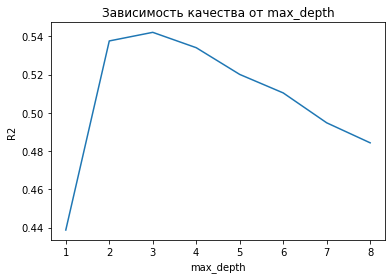

In [37]:
plt.title("Зависимость качества от max_depth")
plt.plot((param_grid["max_depth"]), gs.cv_results_['mean_test_score'])
plt.xlabel("max_depth")
plt.ylabel("R2")

In [38]:
gs.cv_results_['mean_test_score']

array([0.43880929, 0.53760462, 0.54210245, 0.53407071, 0.52011116,
       0.51044952, 0.494833  , 0.48436736])

Результаты на графике вполне ожидаемы - сначала качество растет с повышением параметра максимальной глубины дерева, а затем падает в связи с тем, что модель, возможно, переобучается. Для того, чтобы избежать переобучения, возьму max_depth равный 3.

In [39]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}

In [40]:
gs = GridSearchCV(GradientBoostingRegressor(learning_rate=0.01 , n_estimators=256, 
                                            max_depth=3, random_state=1, warm_start=True), param_grid, 
                                            make_scorer(r2_score), cv=3, verbose=3)

C:\Python\ANACONDA\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [41]:
gs.fit(x1,y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.247, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.339, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.180, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.245, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.342, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.180, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.246, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.334, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.178, total=   0.1s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=81 ........
[CV]  max_features=2, min_sampl

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.3min finished


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                 n_estimators=256,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_features': array([  2,   8,  32, 128], dtype=int32),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring=make_scorer(r2_score), verbose=3)

In [42]:
order = np.argsort(gs.cv_results_['mean_test_score'])
cv_res = np.array(gs.cv_results_['params'])
cv_res[np.array(order)][-1]

{'max_features': 128, 'min_samples_leaf': 3, 'min_samples_split': 27}

In [43]:
gb_model = GradientBoostingRegressor(learning_rate=0.01 , n_estimators=256, max_depth=3, 
                                     max_features=128, min_samples_leaf=3, min_samples_split=81, random_state=1)

In [44]:
gb_model.fit(x1, y1)

GradientBoostingRegressor(learning_rate=0.01, max_features=128,
                          min_samples_leaf=3, min_samples_split=81,
                          n_estimators=256, random_state=1)

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей. Какой из трех вариантов работает лучше?

In [45]:
from sklearn.metrics import r2_score
r2_score(y2,rf_model.predict(x2))

0.5582223506501627

In [46]:
r2_score(y2,gb_model.predict(x2))

0.5571971649602394

In [47]:
mean_model = (rf_model.predict(x2)+gb_model.predict(x2))/2.0

In [48]:
r2_score(y2,mean_model)

0.5591526644127611

Лучше всего работает модель, представляющая собой усреднение предсказаний случайного леса и градиентного бустинга.

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
x2_rf = rf_model.predict(x2)
x2_gb = gb_model.predict(x2)

In [51]:
x2_blend = np.array([x2_rf,x2_gb]).reshape(-1,2)

In [52]:
x2_blend.shape

(1000, 2)

In [53]:
lr_model = LinearRegression(normalize=True)

In [54]:
lr_model.fit(x2_blend, y2)

LinearRegression(normalize=True)

__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга. Какая из четырех моделей работает лучше? Работает ли блендинг лучше усреднения? Выведите веса блендинга, какой из базовых алгоритмов вносит большой вклад в итоговую модель?

In [55]:
r2_score(y3,rf_model.predict(x3))

0.6092559546814411

In [56]:
r2_score(y3,gb_model.predict(x3))

0.608197310324434

In [57]:
mean_model = (rf_model.predict(x3)+gb_model.predict(x3))/2.0
r2_score(y3,mean_model)

0.6102623871748524

In [58]:
x3_blend = np.array([rf_model.predict(x3),gb_model.predict(x3)]).reshape(-1,2)

In [59]:
r2_score(y3,lr_model.predict(x3_blend))

-0.0030055397356343327

Лучше всего работает модель, представляющая собой усреднение предсказаний случайного леса и градиентного бустинга. Блендинг показал плохой результат.

In [60]:
lr_model.coef_

array([-0.01464327, -0.00496229])

In [61]:
lr_model.intercept_

102.81648415888243

 В итоговой модели больший вес имеет случайный лес.